In [14]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [15]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                        data["sub_experiment_path"] = seed_path
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    cfg_data["sub_experiment_path"] = seed_folder_path 
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            key = f"sub_exp_cfg_{key.strip()}"  # Add prefix
            variables[key] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [16]:
experiment_sub_dir = "2025Mar20-101038_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_estimator.args_.lin_hidden_out_size',
       'sub_experiment_path', 'seed', 'experiment_name'],
      dtype='object')

In [17]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_experiment_path,seed,experiment_name
0,training,200000,-222.163417,-43.554373,-100.625184,-106.094447,2.479503e+01,-31.059832,-18.931185,-23.581727,...,-0.758557,-0.613703,0.579056,24374.0,48.0,0 days 00:01:52.034467,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
1,training,400000,-154.074902,-91.163892,-114.414160,-113.819166,8.729237e+00,-27.633248,-20.260834,-23.176197,...,-1.522847,-1.318500,0.758662,25000.0,48.0,0 days 00:01:56.888015,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
2,training,600000,-136.759239,-86.186818,-106.545395,-105.996423,6.179812e+00,-28.588461,-20.076542,-22.678502,...,-1.714951,-1.415652,0.886267,25000.0,48.0,0 days 00:02:04.312429,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
3,training,800000,-129.787998,-69.599706,-99.898026,-100.350751,7.477306e+00,-27.038151,-20.043885,-22.435743,...,-1.758819,-1.374995,0.965948,25000.0,48.0,0 days 00:02:06.145810,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
4,training,1000000,-104.021283,-38.924740,-67.066444,-66.587408,8.798589e+00,-26.608418,-17.872777,-22.122085,...,-2.072416,-2.078292,1.313233,25000.0,56.0,0 days 00:02:03.663731,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,validation,3200000,-56.537456,-56.537456,-56.537456,-56.537456,7.105427e-15,-20.163990,-20.163990,-20.163990,...,-1.718614,-1.339924,1.249162,NaN,NaN,0 days 00:00:00.478060,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0002_estimator.args_.lin_hidden_out_size_128
116,validation,3400000,-52.027363,-51.969281,-51.972338,-51.969281,1.296946e-02,-19.307727,-19.299038,-19.299495,...,-1.589709,-1.185682,1.184569,NaN,NaN,0 days 00:00:00.440794,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0002_estimator.args_.lin_hidden_out_size_128
117,validation,3600000,-58.821688,-58.821688,-58.821688,-58.821688,0.000000e+00,-19.155502,-19.155502,-19.155502,...,-1.352679,-0.937514,1.013873,NaN,NaN,0 days 00:00:00.443482,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0002_estimator.args_.lin_hidden_out_size_128
118,validation,3800000,-51.176954,-51.176954,-51.176954,-51.176954,0.000000e+00,-19.053336,-19.053336,-19.053336,...,-1.507279,-1.177446,1.132956,NaN,NaN,0 days 00:00:00.448699,128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0002_estimator.args_.lin_hidden_out_size_128


In [18]:
# normalize rewards?

In [19]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_experiment_path,seed,experiment_name
20,validation,200000,-148.454078,-139.859361,-140.718833,-139.859361,2.578415e+00,-20.570327,-20.554231,-20.555840,...,-1.548030,-1.422606,0.312040,NaN,NaN,0 days 00:00:00.391254,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
21,validation,400000,-111.612913,-111.612913,-111.612913,-111.612913,0.000000e+00,-20.144323,-20.144323,-20.144323,...,-1.669371,-1.421327,0.549896,NaN,NaN,0 days 00:00:00.411189,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
22,validation,600000,-106.695069,-106.215019,-106.647064,-106.695069,1.440152e-01,-20.056258,-20.056184,-20.056251,...,-1.809595,-1.525928,0.609603,NaN,NaN,0 days 00:00:00.394118,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
23,validation,800000,-95.585203,-95.585203,-95.585203,-95.585203,0.000000e+00,-20.118959,-20.118959,-20.118959,...,-1.700567,-1.313200,0.739173,NaN,NaN,0 days 00:00:00.404188,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
24,validation,1000000,-46.978783,-46.120564,-46.152350,-46.120564,1.620770e-01,-19.916437,-19.873103,-19.874708,...,-1.843220,-1.738305,1.494750,NaN,NaN,0 days 00:00:00.400551,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
25,validation,1200000,-32.813365,-32.454202,-32.473984,-32.454202,7.829980e-02,-17.049394,-17.035153,-17.035718,...,-1.148574,-0.605708,1.148165,NaN,NaN,0 days 00:00:00.423812,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
26,validation,1400000,-33.037156,-32.760876,-32.769509,-32.760876,4.807067e-02,-16.856575,-16.801275,-16.803003,...,-1.199979,-0.762209,1.040776,NaN,NaN,0 days 00:00:00.406280,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
27,validation,1600000,-32.721703,-32.474178,-32.481858,-32.474178,4.181480e-02,-16.903683,-16.876341,-16.879979,...,-1.299009,-0.974757,1.052868,NaN,NaN,0 days 00:00:00.417933,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
28,validation,1800000,-32.720749,-32.720749,-32.720749,-32.720749,0.000000e+00,-16.989442,-16.989442,-16.989442,...,-1.365873,-1.061180,1.073556,NaN,NaN,0 days 00:00:00.429223,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32
29,validation,2000000,-35.553901,-35.553901,-35.553901,-35.553901,0.000000e+00,-17.294984,-17.294984,-17.294984,...,-1.299243,-0.961568,1.077225,NaN,NaN,0 days 00:00:00.410050,32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_estimator.args_.lin_hidden_out_size_32


In [20]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_estimator.args_.lin_hidden_out_size    32
Name: 1, dtype: object
Best mean reward: -49.99080876503722


In [21]:
averaged_results

,sub_exp_cfg_estimator.args_.lin_hidden_out_size,episode_rewards_mean,sub_experiment_path
0,128,-73.807395,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,32,-49.990809,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,64,-147.559152,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


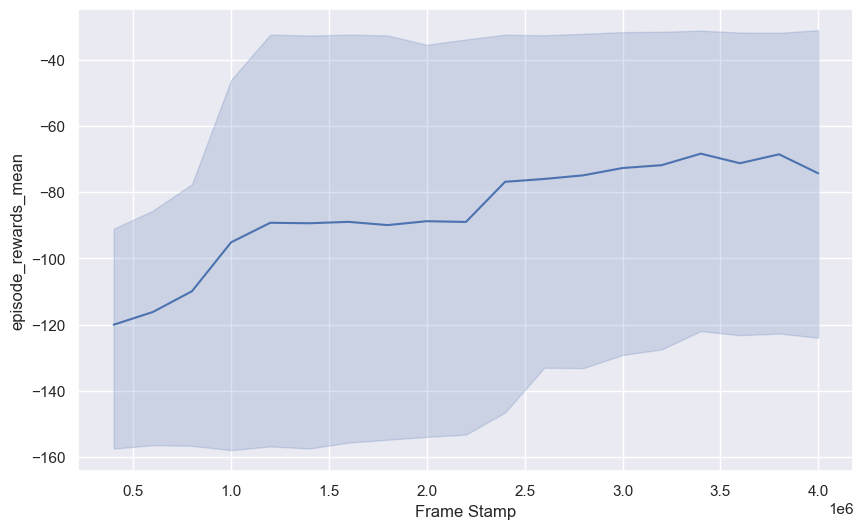

In [22]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

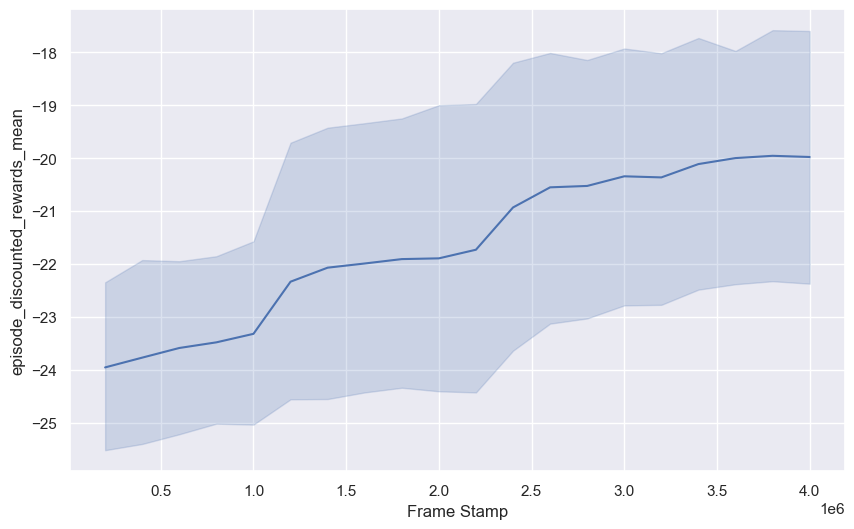

In [23]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [ ]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_estimator.args_.lin_hidden_out_size
39,validation,4000000,-31.136410,28.0,NaN,NaN,0 days 00:00:00.419390,0,0000_estimator.args_.lin_hidden_out_size_32,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,32
79,validation,4000000,-123.984802,100.0,NaN,NaN,0 days 00:00:00.388614,0,0001_estimator.args_.lin_hidden_out_size_64,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,64
119,validation,4000000,-67.926985,100.0,NaN,NaN,0 days 00:00:00.420338,0,0002_estimator.args_.lin_hidden_out_size_128,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,128


In [25]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Mar20-101038_configs\0000_estimator.args_.lin_hidden_out_size_32\0


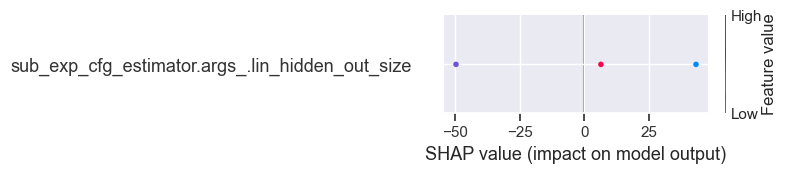

In [26]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)